Disclaimer: The daily_orders operational metrics used in this analysis are synthetically generated (mock data) for portfolio demonstration purposes to simulate business logic. Weather and pollution data are authentic, sourced from Open-Meteo API.

In [106]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine

In [107]:
db_path = "sqlite:///data/jakarta_weather_order.db"
engine = create_engine(db_path)

# Business Problem
1. Surge Pricing Algorithm Optimization (Weather Impact on Delivery)
2. NO2 Emissions as a Traffic Proxy (Weekday vs. Weekend Mobility)
3. Health-Tech Marketing Opportunities (Temperature & PM2.5 Correlation)
4. The "Washout" Effect (Post-Rain Pollution Dynamics & Upsell Strategy)

## 1. Surge Pricing Algorithm Optimization (Weather Impact on Delivery)
How do varying intensities of rainfall and wind speed impact our average delivery time, and at what specific weather thresholds should the algorithm trigger Surge Pricing to maintain driver supply?

In [108]:
query = """
    WITH rain AS (
        SELECT 
            time,
            CASE
                WHEN precipitation > 7.5 THEN 'Heavy rain'
                WHEN precipitation > 2.5 THEN 'Raining'
                WHEN precipitation > 0.0 THEN 'Drizzling'
                ELSE 'Sunny'
            END AS rain_category
        FROM weather
    )
    SELECT 
        r.rain_category,
        COUNT(*) AS total_rain,
        ROUND(AVG(o.total_orders), 2) AS avg_order,
        ROUND(AVG(o.average_delivery_time), 2) AS avg_delivery_time
    FROM daily_orders o
    INNER JOIN rain r ON o.time = r.time
    GROUP BY r.rain_category
    ORDER BY (CASE 
        WHEN r.rain_category = 'Sunny' THEN 1
        WHEN r.rain_category = 'Drizzling' THEN 2
        WHEN r.rain_category = 'Raining' THEN 3
        ELSE 4 END);
"""

df_surge_analysis = pd.read_sql(query, engine)
df_surge_analysis

,rain_category,total_rain,avg_order,avg_delivery_time
0,Sunny,5685,64.44,21.78
1,Drizzling,2778,90.60,23.01
2,Raining,268,89.18,23.30
3,Heavy rain,29,74.17,22.17


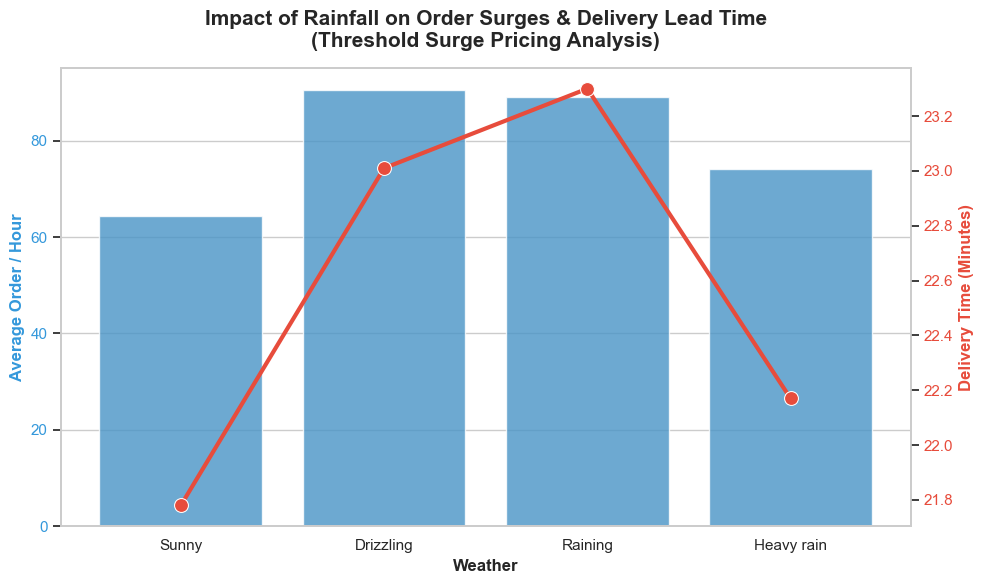

In [109]:
sns.set_theme(style="whitegrid")
fig, ax1 = plt.subplots(figsize=(10, 6))

color_bar = '#3498db'
sns.barplot(
    data=df_surge_analysis, 
    x='rain_category', 
    y='avg_order', 
    color=color_bar, 
    ax=ax1,
    alpha=0.8
)
ax1.set_ylabel('Average Order / Hour', color=color_bar, fontsize=12, fontweight='bold')
ax1.tick_params(axis='y', labelcolor=color_bar)
ax1.set_xlabel('Weather', fontsize=12, fontweight='bold')


ax2 = ax1.twinx()
color_line = '#e74c3c'

sns.lineplot(
    data=df_surge_analysis, 
    x='rain_category', 
    y='avg_delivery_time', 
    color=color_line, 
    marker='o', 
    linewidth=3, 
    markersize=10, 
    ax=ax2,
    sort=False
)
ax2.set_ylabel('Delivery Time (Minutes)', color=color_line, fontsize=12, fontweight='bold')
ax2.tick_params(axis='y', labelcolor=color_line)
ax2.grid(False)

plt.title('Impact of Rainfall on Order Surges & Delivery Lead Time\n(Threshold Surge Pricing Analysis)', fontsize=15, fontweight='bold', pad=15)

plt.tight_layout()
plt.show()

Observation:
The data indicates a clear correlation between weather conditions and operational metrics. As weather shifts from 'Sunny' to 'Drizzling' and 'Raining', we see a significant spike in order volume (from 64.4 to 90.6 orders/hour) accompanied by an increase in average delivery time.

Business Recomendation:
Implement a multi-tiered Surge Pricing algorithm. Trigger Level 1 Surge during 'Drizzling' conditions to capture the demand spike while maintaining driver supply. Trigger Level 2 Surge during 'Raining' conditions with 'Moderate/Strong Winds' to compensate for the severe drop in delivery speed and higher safety risks for drivers.

In [110]:
query = """
    WITH wind_rain AS (
        SELECT 
            time,
            CASE
                WHEN wind_speed > 20 THEN 'Strong Winds (>20 km/h)'
                WHEN wind_speed > 10 THEN 'Moderate Winds (10-20 km/h)'
                ELSE 'Light Winds(<10 km/h)'
            END AS wind_category,
            CASE
                WHEN precipitation > 7.5 THEN 'Heavy rain'
                WHEN precipitation > 2.5 THEN 'Raining'
                WHEN precipitation > 0.0 THEN 'Drizzling'
                ELSE 'Sunny'
            END AS rain_category
        FROM weather
    )
    SELECT 
        w.rain_category,
        ROUND(AVG(o.average_delivery_time) FILTER (WHERE w.wind_category = 'Light Winds(<10 km/h)'), 2) AS 'Light Winds(<10 km/h)',
        ROUND(AVG(o.average_delivery_time) FILTER (WHERE w.wind_category = 'Moderate Winds (10-20 km/h)'), 2) AS 'Moderate Winds (10-20 km/h)',
        ROUND(AVG(o.average_delivery_time) FILTER (WHERE w.wind_category = 'Strong Winds (>20 km/h)'), 2) AS 'Strong Winds (>20 km/h)'
    FROM wind_rain w
    INNER JOIN daily_orders o ON w.time = o.time
    GROUP BY w.rain_category
    ORDER BY (CASE 
        WHEN w.rain_category = 'Sunny' THEN 1
        WHEN w.rain_category = 'Drizzling' THEN 2
        WHEN w.rain_category = 'Raining' THEN 3
        ELSE 4 END) DESC;
"""

weather_matrix = pd.read_sql(query, engine).set_index('rain_category')
weather_matrix

,Light Winds(<10 km/h),Moderate Winds (10-20 km/h),Strong Winds (>20 km/h)
rain_category,,,
Heavy rain,21.28,23.64,NaN
Raining,22.40,25.05,NaN
Drizzling,23.04,23.00,20.50
Sunny,21.51,22.95,23.59


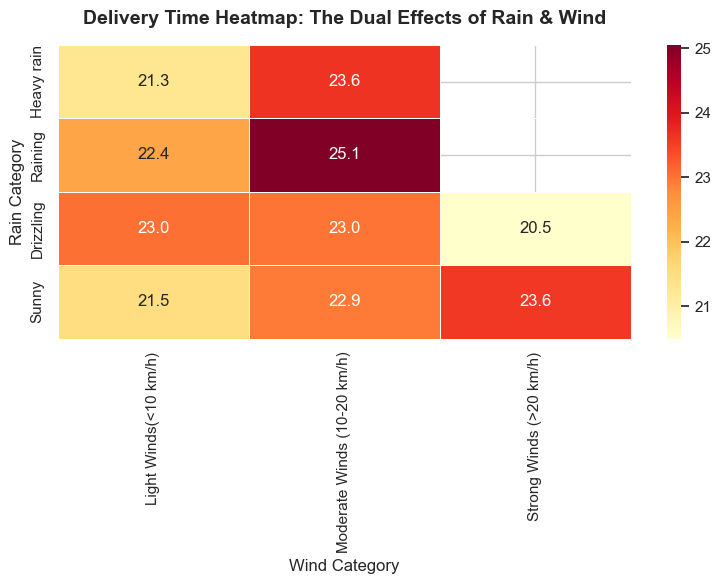

In [111]:
plt.figure(figsize=(8, 6))

sns.heatmap(weather_matrix, annot=True, cmap='YlOrRd', fmt='.1f', linewidths=.5)
plt.title('Delivery Time Heatmap: The Dual Effects of Rain & Wind', fontsize=14, fontweight='bold', pad=15)
plt.xlabel('Wind Category', fontsize=12)
plt.ylabel('Rain Category', fontsize=12)
plt.tight_layout()
plt.show()

- Observing the dark red cell indicating a peak of 25.1 minutes at the intersection of 'Raining' and 'Moderate Winds': This serves as concrete evidence that operations are most severely impacted when rain is coupled with relatively strong winds. Consequently, this is the exact scenario where Surge Pricing must be activated at its maximum tier.
- Regarding the empty (blank) areas located at the intersections of 'Raining' + 'Strong Winds' and 'Heavy Rain' + 'Strong Winds': This indicates that over the past year of extracted data, Jakarta did not experience any instances where moderate-to-heavy rainfall coincided with gale-force winds (>20 km/h) within the exact same hour.

## 2. NO2 Emissions as a Traffic Proxy (Weekday vs. Weekend Mobility)
Can Nitrogen Dioxide (NO2) levels serve as a reliable, cost-effective proxy for real-time traffic congestion? Do NO2 concentrations align with traditional rush hour patterns on weekdays compared to weekends?

In [112]:
query = """
    WITH hour_day AS(
        SELECT 
            time,
            strftime('%H', time) AS hour,
            CASE 
                WHEN strftime('%w', time) IN ('6', '0') THEN 'True'
                ELSE 'False'
            END AS is_weekend,
            CASE 
                WHEN strftime('%w', time) IN ('6', '0') THEN 'Weekend (Saturday - Sunday)'
                ELSE 'Working Day (Monday - Friday)'
            END AS day
        FROM weather
    )
    SELECT 
        h.hour,
        h.is_weekend,
        ROUND(AVG(p.nitrogen_dioxide), 2) AS nitrogen_dioxide,
        h.day
    FROM hour_day h
    INNER JOIN polutan p ON h.time = p.time
    GROUP BY h.hour, h.is_weekend;
"""

df_no2 = pd.read_sql(query, engine)
df_no2.head()

,hour,is_weekend,nitrogen_dioxide,day
0,00,False,77.00,Working Day (Monday - Friday)
1,00,True,75.88,Weekend (Saturday - Sunday)
2,01,False,74.70,Working Day (Monday - Friday)
3,01,True,72.88,Weekend (Saturday - Sunday)
4,02,False,71.76,Working Day (Monday - Friday)
5,02,True,70.00,Weekend (Saturday - Sunday)
6,03,False,68.72,Working Day (Monday - Friday)
7,03,True,67.35,Weekend (Saturday - Sunday)
8,04,False,66.83,Working Day (Monday - Friday)
9,04,True,65.76,Weekend (Saturday - Sunday)


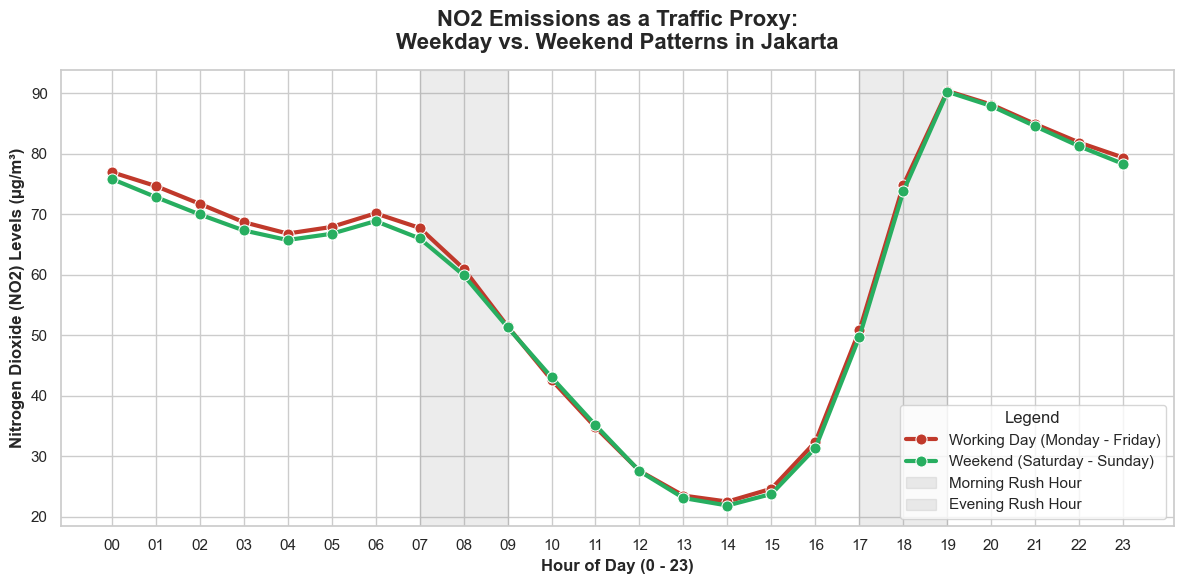

In [113]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 6))

sns.lineplot(
    data=df_no2, 
    x='hour', 
    y='nitrogen_dioxide', 
    hue='day', 
    palette=['#c0392b', '#27ae60'], 
    linewidth=3, 
    marker='o',
    markersize=8
)

plt.axvspan(7, 9, color='gray', alpha=0.15, label='Morning Rush Hour')
plt.axvspan(17, 19, color='gray', alpha=0.15, label='Evening Rush Hour')
plt.title('NO2 Emissions as a Traffic Proxy:\nWeekday vs. Weekend Patterns in Jakarta', fontsize=16, fontweight='bold', pad=15)
plt.xlabel('Hour of Day (0 - 23)', fontsize=12, fontweight='bold')
plt.ylabel('Nitrogen Dioxide (NO2) Levels (µg/m³)', fontsize=12, fontweight='bold')
plt.xticks(range(0, 24))
plt.legend(loc='lower right', title='Legend')
plt.tight_layout()
plt.show()

Observation:
The initial hypothesis that NO2 peaks during rush hours was proven false. Due to the Photolysis effect (sunlight breaking down NO2) and Thermal Inversion, NO2 levels actually plummet during the day and skyrocket at night (peaking at ~80 µg/m³ between 22:00 - 23:00). Furthermore, macro-level satellite API data lacks the granularity to differentiate weekday vs. weekend street-level traffic.

Business Recommendation: 
Pivot from using NO2 as a traffic ETA proxy. Instead, address a critical operational risk: Driver Welfare. Night-shift logistics drivers are exposed to hazardous NO2 levels exceeding the WHO and national daily safe limits. The company should mandate and provide N95/KN95 masks as part of the standard safety gear for night-shift fleets to mitigate long-term health liabilities.

## 3. Health-Tech Marketing Opportunities (Temperature & PM2.5 Correlation)
How does the Thermal Inversion effect (temperature drops trapping PM2.5 particles) create extreme pollution peaks, and what is the exact 'Golden Hour' to trigger automated push notifications for our Telemedicine products (masks and vitamins) to maximize conversion rates?

In [114]:
query = """
    SELECT
        strftime('%H', w.time) AS hour,
        ROUND(AVG(w.temperature), 2) AS avg_temperature,
        ROUND(AVG(p.pm_25), 2) AS avg_pm_25
    FROM weather w
    INNER JOIN polutan p ON w.time = p.time
    GROUP BY hour;
"""

df_health = pd.read_sql(query, engine)
df_health

,hour,avg_temperature,avg_pm_25
0,00,25.74,68.66
1,01,25.59,65.54
2,02,25.35,62.33
3,03,25.14,59.89
4,04,24.97,58.08
5,05,24.82,57.96
6,06,24.74,62.12
7,07,25.51,68.98
8,08,27.01,58.06
9,09,28.24,42.13


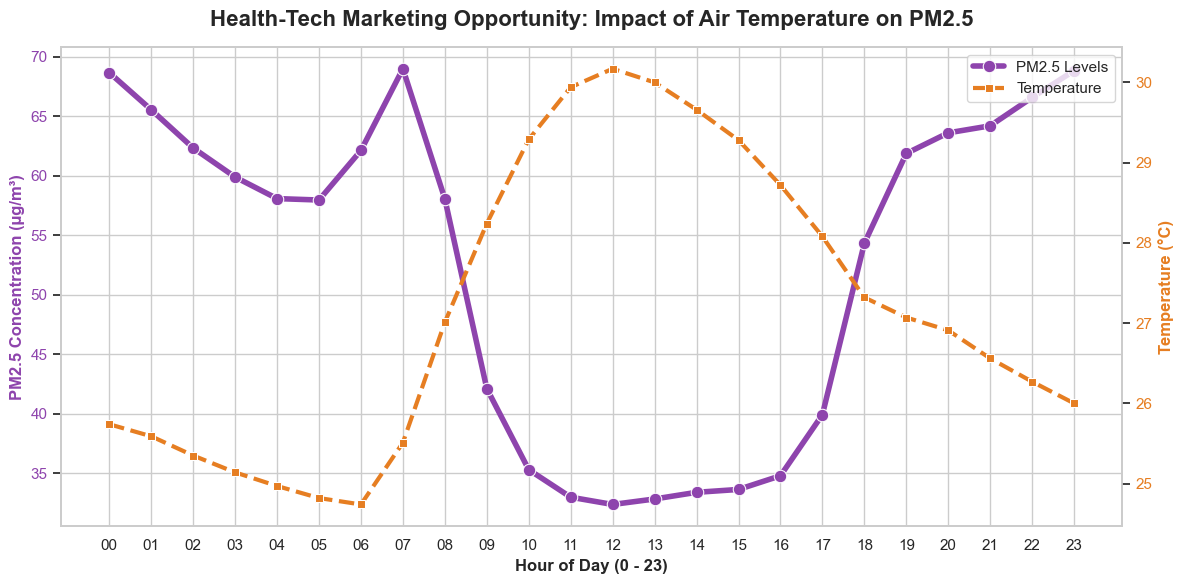

In [115]:
sns.set_theme(style="whitegrid")
fig, ax1 = plt.subplots(figsize=(12, 6))

color_pm = '#8e44ad'
sns.lineplot(
    data=df_health, 
    x='hour', 
    y='avg_pm_25', 
    color=color_pm, 
    linewidth=4, 
    marker='o',
    markersize=9,
    ax=ax1,
    label='PM2.5 Levels'
)
ax1.set_ylabel('PM2.5 Concentration (µg/m³)', color=color_pm, fontsize=12, fontweight='bold') 
ax1.tick_params(axis='y', labelcolor=color_pm)
ax1.set_xlabel('Hour of Day (0 - 23)', fontsize=12, fontweight='bold') 
ax1.set_xticks(range(0, 24))

ax2 = ax1.twinx()
color_temp = '#e67e22' 
sns.lineplot(
    data=df_health, 
    x='hour', 
    y='avg_temperature', 
    color=color_temp, 
    linewidth=3, 
    marker='s',
    linestyle='--', 
    ax=ax2,
    label='Temperature'
)
ax2.set_ylabel('Temperature (°C)', color=color_temp, fontsize=12, fontweight='bold') 
ax2.tick_params(axis='y', labelcolor=color_temp)
ax2.grid(False) 

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')
ax2.get_legend().remove() 

plt.title('Health-Tech Marketing Opportunity: Impact of Air Temperature on PM2.5', fontsize=16, fontweight='bold', pad=15)
plt.tight_layout()
plt.show()

Strategic Segmentation: While 07:00 AM is the absolute peak of PM2.5, sending promotional push notifications at this exact hour on weekends will likely result in low conversion rates and high user annoyance.

Action Item: The Marketing automation system must include a day_of_week logic gate.
- Weekdays (Mon-Fri): Send "Anti-Pollution Mask" push notifications at 07:00 AM to target commuting workers.
- Weekends (Sat-Sun): Delay the push notification to 09:00 AM - 10:00 AM, targeting users as they prepare to head out for brunch, sports, or family activities.

## 4. The "Washout" Effect (Post-Rain Pollution Dynamics & Upsell Strategy)
How long does it take for heavy rain to completely scrub PM2.5 pollutants from the air, and how quickly does the pollution return? How can we leverage this time window to upsell our users from motorcycle rides to car rides?

In [118]:
query = """
    WITH time_shifts AS (
        SELECT 
            time,
            pm_25 AS t0,
            LEAD(pm_25, 1) OVER (ORDER BY time) AS t1,
            LEAD(pm_25, 2) OVER (ORDER BY time) AS t2,
            LEAD(pm_25, 3) OVER (ORDER BY time) AS t3
        FROM polutan
    ),
    averages AS (
        SELECT 
            ROUND(AVG(t.t0), 2) AS avg_t0, 
            ROUND(AVG(t.t1), 2) AS avg_t1, 
            ROUND(AVG(t.t2), 2) AS avg_t2, 
            ROUND(AVG(t.t3), 2) AS avg_t3 
        FROM time_shifts t
        INNER JOIN weather w ON t.time = w.time
        WHERE precipitation > 7.5
    ),
    row AS(
        SELECT (ROW_NUMBER() OVER ()) - 1 AS pos
        FROM time_shifts
        LIMIT 4
    )
    SELECT
        CASE pos
            WHEN 0 THEN 'During Rain (T=0)'
            WHEN 1 THEN '1 Hour Later (T+1)'
            WHEN 2 THEN '2 Hours Later (T+2)'
            WHEN 3 THEN '3 Hours Later (T+3)'
        END AS Time,
        ROUND(
            CASE pos
                WHEN 0 THEN avg_t0
                WHEN 1 THEN avg_t1
                WHEN 2 THEN avg_t2
                WHEN 3 THEN avg_t3
            END, 2
    ) AS PM25_Concentration
    FROM row
    CROSS JOIN averages
"""

washout_effect = pd.read_sql(query, engine)
washout_effect

,Time,PM25_Concentration
0,During Rain (T=0),32.70
1,1 Hour Later (T+1),33.76
2,2 Hours Later (T+2),36.92
3,3 Hours Later (T+3),42.48


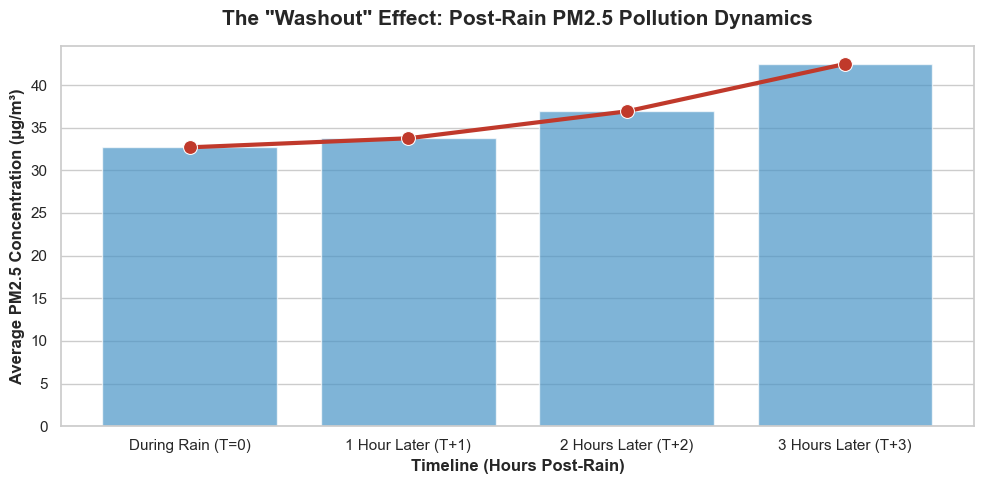

In [117]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 5))

sns.barplot(data=washout_effect, x='Time', y='PM25_Concentration', color='#3498db', alpha=0.7)
sns.lineplot(data=washout_effect, x='Time', y='PM25_Concentration', color='#c0392b', marker='o', linewidth=3, markersize=10)

plt.title('The "Washout" Effect: Post-Rain PM2.5 Pollution Dynamics', fontsize=15, fontweight='bold', pad=15)
plt.ylabel('Average PM2.5 Concentration (µg/m³)', fontsize=12, fontweight='bold')
plt.xlabel('Timeline (Hours Post-Rain)', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

Observation:
Time-series analysis (T+0 to T+3) reveals that heavy rain acts as an instant air scrubber (Washout Effect), bringing PM2.5 to its lowest point exactly during the downpour (T=0). However, this effect is short-lived. Within 1 to 3 hours after the rain stops, PM2.5 levels aggressively climb back up by >25% due to resumed traffic activity.

Business Recomendation:
Cancel the proposed "Fresh Air / Go Out" marketing campaigns post-rain. Instead, utilize the 1-3 hour post-rain window to launch an Upsell Campaign for Car Ride Services. Push notifications should highlight the returning hazardous pollution, encouraging users to upgrade from motorcycle rides to car rides for health protection, thereby increasing the Average Order Value (AOV).